In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 1

# 関数・ユーティリティ

In [2]:
def show_plot(coef, value, coef_expected = None, value_expected = None, suptitle=None):
    # Plot signal and result
    
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    plt.plot(coef, label='original')
    if coef_expected is not None:
        plt.plot(coef_expected, label='expected')    
    plt.title('coeficients')
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(value, label='original')
    if value_expected is not None:
        plt.plot(value_expected, label='expected')        
    
    plt.title('value')
    plt.legend()
    plt.grid()
    
    if suptitle is not None:
        plt.suptitle(suptitle)    

    plt.tight_layout()    
    if suptitle is not None:
        plt.subplots_adjust(top=0.85)

# 線形回帰でのスパースモデリング

## 観測情報 y と入力特徴量 x の準備

In [3]:
# シードの設定
np.random.seed(0)

# 特徴量とサンプルサイズ
n_features = 1000
n_samples = 100
n_nonzero_coefs = 20
n_iter = 1000

# 正則化パラメータ
alpha = 0.5

In [4]:
# 真の重みの生成

idx = np.random.randint(0, n_features, n_nonzero_coefs)
w = np.zeros(n_features)
w[idx] = np.random.normal(0.0, 1.0, n_nonzero_coefs)

In [5]:
# 入力データと観測情報

X = np.random.normal(0.0, 1.0, (n_samples, n_features))
y = X.dot(w) + np.random.normal(0.0, 1.0, n_samples)

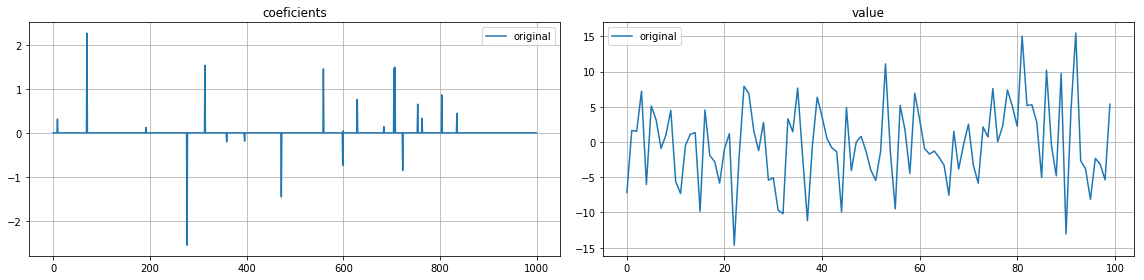

In [6]:
show_plot(w, y)

## sklearn の LASSO 実装

In [7]:
%%time
from sklearn.linear_model import Lasso

model = Lasso(alpha=alpha, max_iter=n_iter).fit(X, y)
w_ = model.coef_
p_ = model.predict(X)

CPU times: user 200 ms, sys: 180 ms, total: 380 ms
Wall time: 503 ms


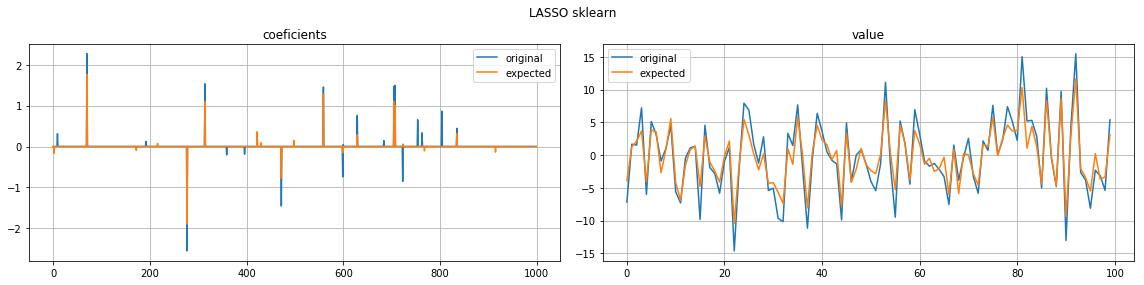

In [8]:
show_plot(w, y, w_, p_, 'LASSO sklearn')

In [9]:
len(np.where(w_ == 0)[0])

979

## 座標降下法

In [10]:
def soft_threshold(X, thresh):
    return np.where(np.abs(X) <= thresh, 0, X - thresh * np.sign(X))

In [11]:
%time

w_cd = np.zeros(n_features)
for _ in range(n_iter):
    for j in range(n_features):
        w_cd[j] = 0.0
        r_j = y - np.dot(X, w_cd)
        w_cd[j] = soft_threshold(np.dot(X[:, j], r_j) / n_samples, alpha)        

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 16 µs


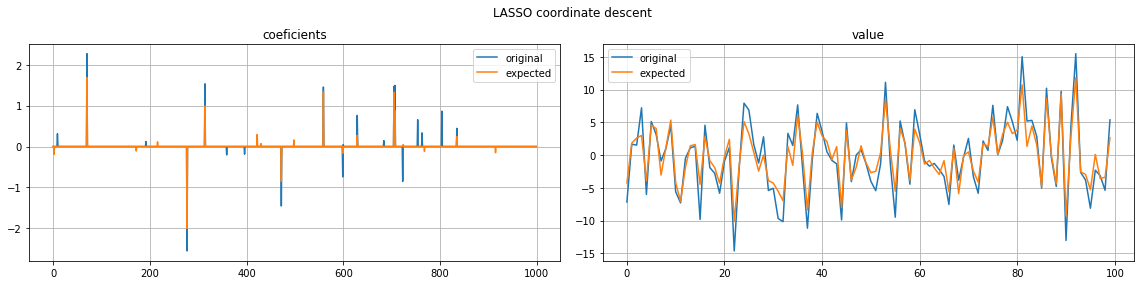

In [12]:
show_plot(w, y, w_cd, np.dot(X, w_cd), 'LASSO coordinate descent')

In [13]:
len(np.where(w_cd == 0)[0])

981

# 画像処理への適用

## 下準備

In [14]:
patch_size = (8, 8)

n_basis = 64
n_iter = 1000

(768, 1024)


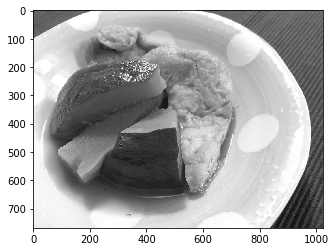

In [15]:
import cv2

img = cv2.imread('data/recipe.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(img.shape)
plt.imshow(img, cmap='gray')

## 辞書学習

In [16]:
%%time

# パッチの切り出し
from spmimage.feature_extraction.image import extract_simple_patches_2d, reconstruct_from_simple_patches_2d
patches = extract_simple_patches_2d(img, patch_size)
print(patches.shape)

(12288, 8, 8)
CPU times: user 190 ms, sys: 100 ms, total: 290 ms
Wall time: 252 ms


In [17]:
%%time

from sklearn.decomposition import MiniBatchDictionaryLearning

# パッチの前処理
patches = patches.reshape(patches.shape[0], -1).astype(np.float64)
intercept = np.mean(patches, axis=0)
patches -= intercept
patches /= np.std(patches, axis=0)

# 辞書学習
model = MiniBatchDictionaryLearning(n_components=n_basis, alpha=1, n_iter=n_iter, n_jobs=1)
model.fit(patches)

CPU times: user 7.41 s, sys: 520 ms, total: 7.93 s
Wall time: 7.46 s


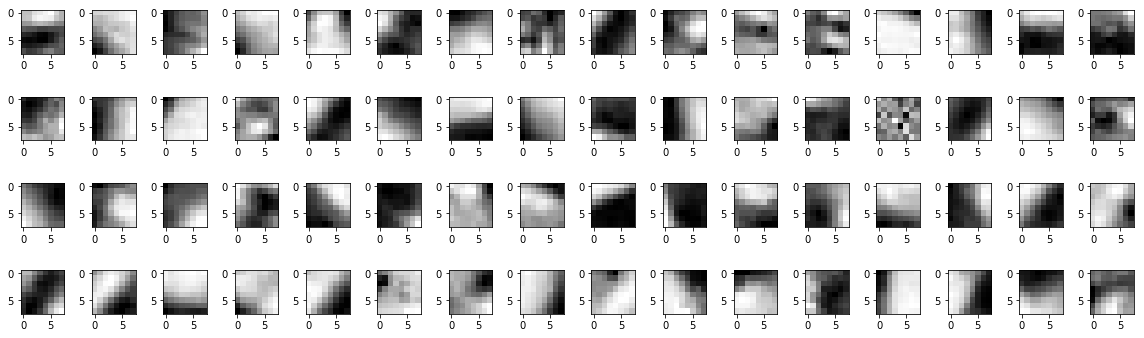

In [18]:
# 辞書の表示

n_cols = 16
n_rows = (n_basis // n_cols) + 1

plt.figure(figsize=(16, 6))

for i, base in enumerate(model.components_):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(base.reshape(patch_size), 'gray', interpolation='nearest')

plt.tight_layout()

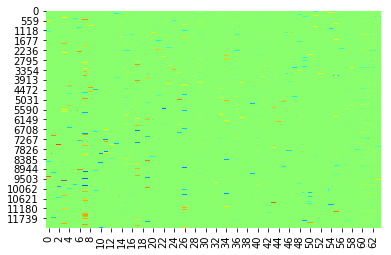

In [19]:
# 元データの係数行列

code = model.transform(patches)
sns.heatmap(code, cmap='jet', cbar=False)

CPU times: user 360 ms, sys: 300 ms, total: 660 ms
Wall time: 577 ms


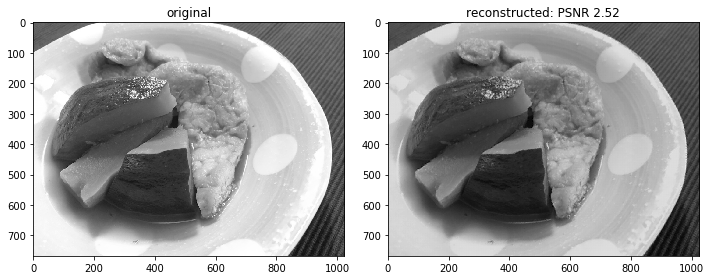

In [20]:
%%time
# 再構成をかける

from skimage.measure import compare_psnr

reconstructed_patches = np.dot(code, model.components_)
reconstructed_patches = reconstructed_patches.reshape(len(patches), *patch_size)

reconstructed = reconstruct_from_simple_patches_2d(reconstructed_patches, img.shape)
recipe_psnr = compare_psnr(img, reconstructed.astype(np.uint8))

plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plt.imshow(img, 'gray')
plt.title(f'original')

plt.subplot(1,2,2)
plt.imshow(reconstructed, 'gray')
plt.title(f'reconstructed: PSNR {recipe_psnr:.02f}')

plt.tight_layout()